# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/theo/Kaggle/seversal/src


In [3]:
from util import *
from metric import *
from params import *
from imports import *
from post_process import *
from pseudo_labeling import *

Kept 1547 images out of 1801
Number of defects of class 0 : 75
Number of defects of class 1 : 3
Number of defects of class 2 : 564
Number of defects of class 3 : 93


In [4]:
from data.masks import *
from data.dataset import *
from data.transforms import *
from data.transforms import get_transforms as transfos

In [57]:
from training.train import *
from training.freezing import *
from training.predicting import *

In [6]:
from model_zoo.unet import *
from model_zoo.fpn_enetb5 import *
from model_zoo.classifiers import *
from model_zoo.unet_densenet169 import *
from model_zoo.unet_seresnext50 import *

In [7]:
from tqdm import tqdm_notebook as tqdm

sns.set_style('white')
KERNEL_START_TIME = time.time()
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.simplefilter(action='ignore', category=RuntimeWarning)
print('Number of available cores :', multiprocessing.cpu_count())

Number of available cores : 16


# Parameters

In [8]:
seed = 2019
seed_everything(seed)

In [9]:
TRAIN_IMG_PATH = '../input/train_images/'
TEST_IMG_PATH = '../input/test_images/'
DATA_PATH = '../input/'

In [10]:
IMG_SHAPE = (256, 1600)

In [11]:
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

In [12]:
NUM_WORKERS = 4

VAL_BS = 4 

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Data

In [13]:
CP_PATH = f'../checkpoints/{date.today()}/'
if not os.path.exists(CP_PATH):
    os.mkdir(CP_PATH)

In [14]:
df_train = pd.read_csv(DATA_PATH + 'train.csv')
df_train['EncodedPixels'].fillna('-1', inplace=True)

print('Number of training images : ', len(df_train) // 4)

Number of training images :  12568


In [15]:
df_train['ImageId'] = df_train['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
df_train['ClassId'] = df_train['ImageId_ClassId'].apply(lambda x: x.split('_')[1])

group_img = df_train[['ImageId', 'EncodedPixels']].groupby('ImageId').agg(list)
rep_classes = group_img['EncodedPixels'].apply(pd.Series).rename(columns=lambda x : str(x))
rep_classes['ClassNumber'] = group_img['EncodedPixels'].apply(lambda x: len([i for i in x if i != "-1"]))

all_images = rep_classes.index.values
hard_negatives = rep_classes[rep_classes['ClassNumber'] == 0].index.values
positives = rep_classes[rep_classes['ClassNumber'] > 0].index.values

print('Number of images with defaults: ', len(positives))

Number of images with defaults:  6666


In [16]:
mask_dic = rep_classes.drop('ClassNumber', axis=1).to_dict('index')

In [17]:
classes, classes_max = get_classes(all_images, mask_dic)

## Training

In [18]:
def k_fold_training(create_model, backbone, images, classes, classes_max, mask_dic, transforms_dic,
                    kept_for_training=([],), k=5, selected_fold=0, use_aux_clf=False,
                    batch_sizes=(32,), epochs=(5,), seed=2019, lr=(1e-3,), min_lrs=(1e-5,),
                    verbose=1, save=True, cp=False, warmup_props=(0.1,), model_name="model", pretrained_path=''):
    
    splits = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=seed).split(images, classes_max))
    train_idx, val_idx = splits[selected_fold]
    i = selected_fold
    
    pred_oof = np.zeros((len(images), IMG_SHAPE[0], IMG_SHAPE[1]), dtype=np.uint8)

    print(f"-------------   Fold {i+1}  -------------")
    
    seed_everything(seed + i)
    start_time = time.time()

    if backbone in SETTINGS.keys():
        model = build_model(SETTINGS[backbone], num_classes=4, center_block=None)
    else:
        model = build_model(_, num_classes=4, center_block=None)

    if len(pretrained_path):
        load_model_weights(model, pretrained_path)
    
    train_dataset = SteelTrainDatasetClf(mask_dic, images[train_idx], classes[train_idx], transforms_dic["train"], kept_imgs=[])
    val_dataset = SteelValDatasetClf(mask_dic, images[val_idx], classes[val_idx], transforms_dic["val"])
    
    print('\n - Training with Cosine \n')

    fit_clf(model, train_dataset, val_dataset, epochs=epochs[0], batch_size=batch_sizes[0], 
            lr=lr[0], min_lr=lrs_min[0], schedule='cosine', use_aux_clf=False,
            warmup_prop=warmup_props[0], verbose=verbose, cp=cp, model_name=f"{model_name}_{i+1}_0.pt")
    
    if cp:
        load_model_weights(model, f"{model_name}_{i+1}_0.pt", verbose=1)
    elif save:
        save_model_weights(model, f"{model_name}_{i+1}_0.pt", verbose=1)


# Training

## Parameters

In [19]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [20]:
backbone = 'enetb5'
build_model = Classifier
model_name = backbone

In [21]:
backbone = 'resnet34' #resnet18
build_model = Classifier
model_name = backbone + "pl"

In [22]:
kept_images = [[], []]

In [23]:
k = 5
selected_fold = 0

In [24]:
CROP_SIZE = 0
transforms_dic = {"train": transfos(crop_size=CROP_SIZE),
                  "val": transfos(test=True)}

transforms_dic = {"train": transfos(crop_size=CROP_SIZE),
                  "val": transfos(test=True)}

batch_sizes = [16]

epochs = [1] #[30]

warmup_props = [0] # [0.1]
lrs = [5e-4]
lrs_min = [1e-5]

In [25]:
tta = True

## Train

In [31]:
assert torch.cuda.is_available(), 'Training on GPU is mandatory'

k_fold_training(build_model, backbone, all_images, classes, classes_max, mask_dic, transforms_dic,
                k=k, selected_fold=selected_fold,
                batch_sizes=batch_sizes, epochs=epochs, warmup_props=warmup_props, lr=lrs, min_lrs=lrs_min,
                verbose=1, save=True, cp=False, model_name=model_name, seed=seed)

-------------   Fold 1  -------------

 - Training with Cosine
Epoch 1/1     lr=1.0e-05     t=208s     loss=0.3592     val_loss=0.2871     val_acc=0.7256

 -> Saving weights to ../checkpoints/resnet34pl_1_0.pt



# Validation

## Retrieving models

In [32]:
model_weights = [
    f"{model_name}_{selected_fold+1}_0.pt",
]

In [33]:
models = []
for weights in model_weights:
    if backbone in SETTINGS.keys():
        model = build_model(SETTINGS[backbone], num_classes=4, center_block=None).to(DEVICE)
    else:
        model = build_model(_, num_classes=4, center_block=None).to(DEVICE)
    try:
        model = load_model_weights(model, weights, verbose=1)
        models.append(model)
    except:
        print(f'Error loading {weights}')
        pass


 -> Loading weights from ../checkpoints/resnet34pl_1_0.pt



In [34]:
model = UneXt50SE_c(_, pre=False).to(DEVICE)
model = load_model_weights(model, "UneXt50SE2_1_0_c.pt", verbose=1, cp_folder='../saved_cps/final/')


 -> Loading weights from ../saved_cps/final/UneXt50SE2_1_0_c.pt



## Retrieving data

In [35]:
splits = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=seed).split(all_images, classes_max))
val_idx = splits[selected_fold][1]
post_process_idx, pp_val_idx = train_test_split(val_idx, test_size=0.5, random_state=seed)

val_dataset = SteelValDatasetClf(mask_dic, all_images[val_idx], classes[val_idx], transfos(test=True))
post_process_dataset = SteelValDatasetClf(mask_dic, all_images[post_process_idx], classes[post_process_idx], transfos(test=True))
pp_val_dataset = SteelValDatasetClf(mask_dic, all_images[pp_val_idx], classes[pp_val_idx], transfos(test=True))

## Predicting

In [36]:
faults_pred, faults_pred_max = predict_faults_with_aux(val_dataset, model, tta=tta)

In [38]:
prob_thresholds = tweak_thresholds_clf(faults_pred, classes[val_idx])
print(prob_thresholds)

[0.54 0.51 0.5  0.67]


In [39]:
prob_thresholds_max = tweak_thresholds_clf(faults_pred_max, classes[val_idx])
print(prob_thresholds_max)

[0.57 0.43 0.62 0.61]


In [41]:
PROBS = np.load('../output/probs_kfold_pl.npy')
PROBS_VAL = PROBS[val_idx]
prob_thresholds_ref = tweak_thresholds_clf(PROBS_VAL, classes[val_idx])
print(prob_thresholds_ref)

[0.43 0.26 0.28 0.31]


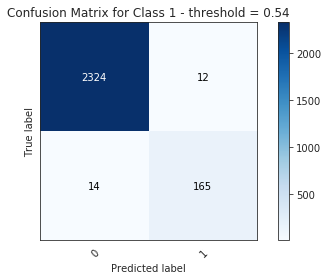

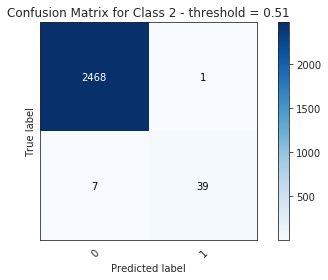

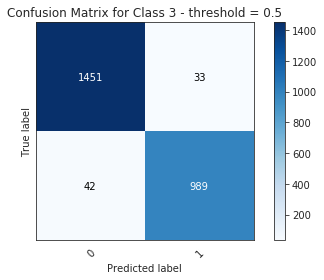

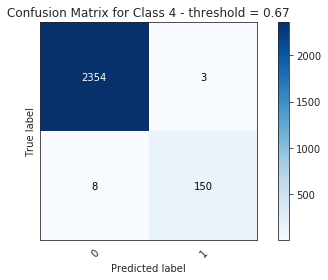

In [46]:
for i in range(4):
    plot_confusion_matrix((classes[val_idx] > 0).astype(int)[:, i], (faults_pred > prob_thresholds[i]).astype(int)[:, i], 
                          title=f'Confusion Matrix for Class {i+1} - threshold = {prob_thresholds[i]}', normalize=False)

## $k$-folds prediction

In [49]:
cp_folder = '../saved_cps/clf/resnet34pl/'

In [50]:
os.listdir(cp_folder)

['resnet34pl_2_2.pt', 'resnet34pl_1_2.pt']

In [51]:
model_name = "resnet34pl"

In [52]:
model_weights = [
    f"{model_name}_1_2.pt",
    f"{model_name}_2_2.pt",
#     f"{model_name}_3_2.pt",
#     f"{model_name}_4_1.pt",
#     f"{model_name}_5_1.pt",
]

In [60]:
models = []
for weights in model_weights:
    model = build_model(SETTINGS["resnet34"], num_classes=4, center_block=None).to(DEVICE)
    try:
        model = load_model_weights(model, weights, verbose=1, cp_folder=cp_folder)
        models.append(model)
    except:
        print(f'Error loading {weights}')
        pass


 -> Loading weights from ../saved_cps/clf/resnet34pl/resnet34pl_1_2.pt


 -> Loading weights from ../saved_cps/clf/resnet34pl/resnet34pl_2_2.pt



In [64]:
faults_pred = k_fold_predictions_clf(models, mask_dic, all_images, classes, classes_max, transfos(test=True), k=5, tta=tta)
np.save(f'../output/probs_kfold_pl.npy', faults_pred)

# faults_pred = np.load(f'../output/probs_kfold_pl.npy')

In [65]:
splits = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=seed).split(all_images, classes_max))
val_idx = np.array(list(splits[0][1]) + list(splits[1][1]))

thresholds = tweak_thresholds_clf(faults_pred[val_idx], classes[val_idx])
print(thresholds)

[0.48 0.28 0.34 0.31]


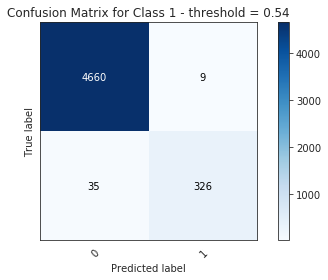

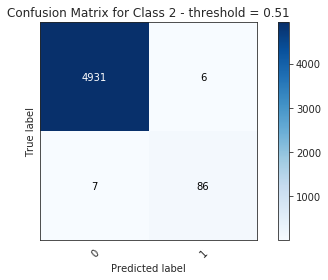

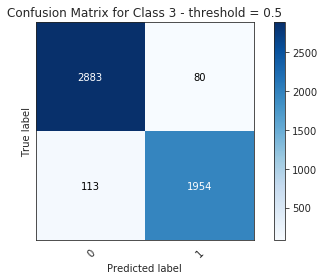

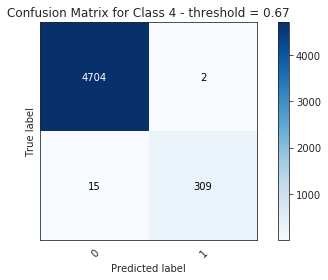

In [66]:
for i in range(4):
    plot_confusion_matrix((classes[val_idx] > 0).astype(int)[:, i], (faults_pred[val_idx] > thresholds[i]).astype(int)[:, i], 
                          title=f'Confusion Matrix for Class {i+1} - threshold = {prob_thresholds[i]}', normalize=False)

## Saving for Validation

In [67]:
# faults_pred_ppv = predict_faults(pp_val_dataset, models[-1], tta=tta)
# faults_pred_pp = predict_faults(post_process_dataset, models[-1], tta=tta)

# np.save(f'../output/probs_{model_weights[-1][:-3]}_pp.npy' , faults_pred_pp)
# np.save(f'../output/probs_{model_weights[-1][:-3]}_ppv.npy' , faults_pred_ppv)
# np.save(f'../output/probs_{model_weights[-1][:-3]}.npy' , faults_pred)